- Organize all the data of the coefficients and the covariance (Done)
- Compute mean coefficients (Done)
- Compute variance (Not sure about this)
- Compute smoothing (Done)
- Compute S/N (Done)
- Select coefficients (Done)
- Print coefficients (Done)


In [1]:
%pylab inline
import biff


Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)


In [3]:
r_s_sims = 40.85
G_gadget=43007.1 #kpc3/(Gyr2Msun)/1E10.

In [4]:
## Reading coefficients
def reshape_matrix(matrix, n, l, m):
    col_matrix = np.zeros((n+1, l+1, m+1))


    counter = 0
    for n in range(n+1):
        for l in range(l+1):
            for m in range(0, l+1):
                col_matrix[n][l][m] = matrix[counter]
                counter +=1
    return col_matrix

In [5]:
## Reading coefficients
def read_coeff_matrix(filename, nfiles, n, l, m, nmin=0, nmax=1000):
    print(nmax)

    S_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    T_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    
    S_mean = np.zeros((int((n+1)*(l+1)*(l/2.+1))))
    T_mean = np.zeros((int((n+1)*(l+1)*(l/2.+1))))

    for i in range(nmin, nmax):
        coeff = np.loadtxt(filename + '{:03d}.txt'.format(i))
        S_matrix[:,i] = coeff[:,0]
        T_matrix[:,i] = coeff[:,1]
        
    for i in range(len(S_matrix[:,0])):
        S_mean[i] = np.mean(S_matrix[i])
        T_mean[i] = np.mean(T_matrix[i])

    S_mean_matrix = reshape_matrix(S_mean, n, l, m)
    T_mean_matrix = reshape_matrix(T_mean, n, l, m)

    return S_mean_matrix, T_mean_matrix

## Reading covariance
def var_matrix(filename, filename2, nfiles, n, l, m, mass, nmin=0, nmax=1000):
    print(nmax)

    Scov_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    Tcov_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    
    Svar_mean = np.zeros((int((n+1)*(l+1)*(l/2.+1))))
    Tvar_mean = np.zeros((int((n+1)*(l+1)*(l/2.+1))))
    
    
    S_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    T_matrix = np.zeros((int((n+1)*(l+1)*(l/2.+1)), nfiles))
    
    for i in range(nmin, nmax):
        cov = np.loadtxt(filename + '{:03d}.txt'.format(i))
        coeff = np.loadtxt(filename2 + '{:03d}.txt'.format(i))

        Scov_matrix[:,i] = cov[:,0]
        Tcov_matrix[:,i] = cov[:,1]
        
        S_matrix[:,i] = coeff[:,0]
        T_matrix[:,i] = coeff[:,1]
    

    for i in range(len(Scov_matrix[:,0])):
        Svar_mean[i] = np.mean((Scov_matrix[i] - mass*S_matrix[i]**2)) #/ nfiles
        Tvar_mean[i] = np.mean((Tcov_matrix[i] - mass*T_matrix[1]**2)) #/ nfiles

    Svar_mean_matrix = reshape_matrix(Svar_mean, n, l, m)
    Tvar_mean_matrix = reshape_matrix(Tvar_mean, n, l, m)
        
    return Svar_mean_matrix, Tvar_mean_matrix



In [6]:
def copy_matrix(M, indices):
    M_new = np.zeros(shape(M))
    for i in range(len(indices[0])):
        M_new[indices[0][i]][indices[1][i]][indices[2][i]] = M[indices[0][i]][indices[1][i]][indices[2][i]]
    return M_new

def smoothing(var_coeff, coeff):
    """
    Coefficients smoothing 
    
    """
    b_nlm = 1/(1 + var_coeff/coeff**2)
    # This line remove nans an put the original values
    b_nlm_values = np.nan_to_num(b_nlm)
    return b_nlm_values

def coefficients_smooth_level(S, T, bs, bt, b_cut, verb=0):
    """
    Returns coefficients with energy higher than e_cut
    e_cut : float 
        between 0 and 1
        
    """
 
    bs_cut_index = np.where(bs>b_cut)
    bt_cut_index = np.where(bt>b_cut)
    
    if verb == 1:
        print('N coeff S= ', len(bs_cut_index[0]))
        print('N coeff T= ', len(bt_cut_index[0]))

    S_new = copy_matrix(S, bs_cut_index)
    T_new = copy_matrix(T, bt_cut_index)
    
    return S_new, T_new, len(bs_cut_index[0]), len(bt_cut_index[0])

In [7]:
mass =1.5772125152E-6


In [9]:
S_mean, T_mean  = read_coeff_matrix('../data/bootstrap_mwlmc_1e6_b1/coeff_rand_mwlmc5_b1_1E6_', 1000, 20, 20, 20, nmin=0, nmax=999)
Scov_mean, Tcov_mean  = var_matrix('../data/bootstrap_mwlmc_1e6_b1/cov_matrix_rand_mwlmc5_b1_1E6_',
                                        '../data/bootstrap_mwlmc_1e6_b1/coeff_rand_mwlmc5_b1_1E6_',
                                   1000, 20, 20, 20, 
                                        mass, nmin=0, nmax=999)

999
999


In [13]:
bS = smoothing(Scov_mean, S_mean)
bT = smoothing(Tcov_mean, T_mean)

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [14]:
S_opt, T_opt, NcoeffS ,NcoeffT = coefficients_smooth_level(S_mean, T_mean, bS, bT, 0.5, verb=1)

N coeff S=  1526
N coeff T=  1424


In [12]:
N_coeff_all_S = np.zeros(1000)
N_coeff_all_T = np.zeros(1000)

In [124]:
np.savetxt('./BFE/MW_opt_coeff_b0.txt', np.array([S_opt.flatten(), T_opt.flatten()]).T)

In [121]:
np.savetxt('./BFE/MW_opt_coeff_smooth_b03.txt', np.array([(S_opt*bS).flatten(), (T_opt*bT).flatten()]).T)

In [91]:
j= 0
for i in range(0, 1001, 20):
    S1, T1  = read_coeff_matrix('/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b1/data_bfe/bfe_mwlmc5_b1_1e6/coeff_rand_mwlmc5_b1_1E6_', i+1, 20, 20, 20,
                            nmin=0, nmax=i+1)
    Scov1, Tcov1  = var_matrix('/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b1/data_bfe/bfe_mwlmc5_b1_1e6/cov_matrix_rand_mwlmc5_b1_1E6_',
                               '/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b1/data_bfe/bfe_mwlmc5_b1_1e6/coeff_rand_mwlmc5_b1_1E6_',
                               i+1, 20, 20, 20, mass, nmin=0, nmax=i+1)
    bS1 = smoothing(Scov1, S1)
    bT1 = smoothing(Tcov1, T1)
    S1_opt, T1_opt, N_coeff_all_S[j], N_coeff_all_T[j] = coefficients_smooth_level(S1, T1, bS1, bT1, 0.5, verb=1)
    j+=1
    

1
1


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


N coeff S=  2377
N coeff T=  2581
21
21
N coeff S=  1614
N coeff T=  1886
41
41
N coeff S=  1573
N coeff T=  1849
61
61
N coeff S=  1546
N coeff T=  1829
81
81
N coeff S=  1549
N coeff T=  1829
101
101
N coeff S=  1550
N coeff T=  1827
121
121
N coeff S=  1541
N coeff T=  1822
141
141
N coeff S=  1542
N coeff T=  1819
161
161
N coeff S=  1542
N coeff T=  1819
181
181
N coeff S=  1546
N coeff T=  1822
201
201
N coeff S=  1534
N coeff T=  1811
221
221
N coeff S=  1537
N coeff T=  1816
241
241
N coeff S=  1539
N coeff T=  1817
261
261
N coeff S=  1535
N coeff T=  1815
281
281
N coeff S=  1536
N coeff T=  1818
301
301
N coeff S=  1535
N coeff T=  1814
321
321
N coeff S=  1529
N coeff T=  1810
341
341
N coeff S=  1533
N coeff T=  1812
361
361
N coeff S=  1539
N coeff T=  1814
381
381
N coeff S=  1538
N coeff T=  1819
401
401
N coeff S=  1536
N coeff T=  1813
421
421
N coeff S=  1535
N coeff T=  1815
441
441
N coeff S=  1537
N coeff T=  1813
461
461
N coeff S=  1538
N coeff T=  1819
481
481


In [1]:
plot(np.arange(0, 1001, 20), N_coeff_all_S[:51], c='k')
xlabel('N samples')
ylabel('N coefficients')
savefig('Ncoeff_Nsample.pdf', bbox_inches='tight')

NameError: name 'plot' is not defined

In [55]:
bS1 = smoothing(Scov1, S1)
bT1 = smoothing(Tcov1, T1)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [56]:
S1_opt, T1_opt, Ncoeff = coefficients_smooth_level(S1, T1, bS1, bT1, 0.5, verb=1)

N coeff S=  2377
N coeff T=  2581


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

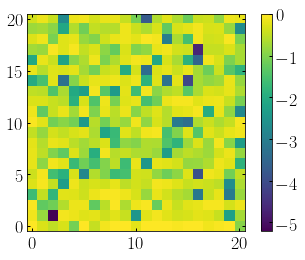

In [57]:
imshow(np.log10(bS[:,:,0]).T, origin='lower')
colorbar()

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


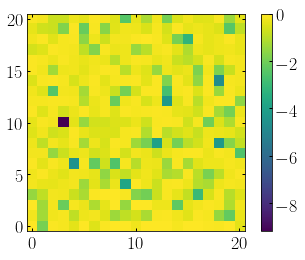

In [58]:
imshow(np.log10(bS1[:,:,0]).T, origin='lower')
colorbar()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


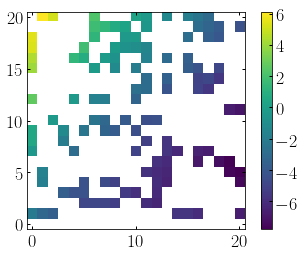

In [59]:
imshow(np.log10(np.abs(bS[:,:,1]*S_opt[:,:,1])).T, origin='lower')
colorbar()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


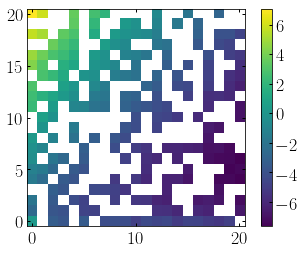

In [60]:
imshow(np.log10(np.abs(S1_opt[:,:,0])).T, origin='lower')
colorbar()

In [15]:
y_grid = np.arange(-300, 300, 5)
z_grid = np.arange(-300, 300, 5)
y_grid, z_grid = meshgrid(y_grid, z_grid)

In [31]:
rho_mwlmc_all= biff.density(np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())), 
                                                            y_grid.flatten(), 
                                                            z_grid.flatten()]).T), 
                           S_mean, T_mean, M=1, r_s=40.85)

In [32]:
rho_mwlmc_opt= biff.density(np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())), 
                                                            y_grid.flatten(), 
                                                            z_grid.flatten()]).T), 
                           S_opt, T_opt, M=1, r_s=40.85)

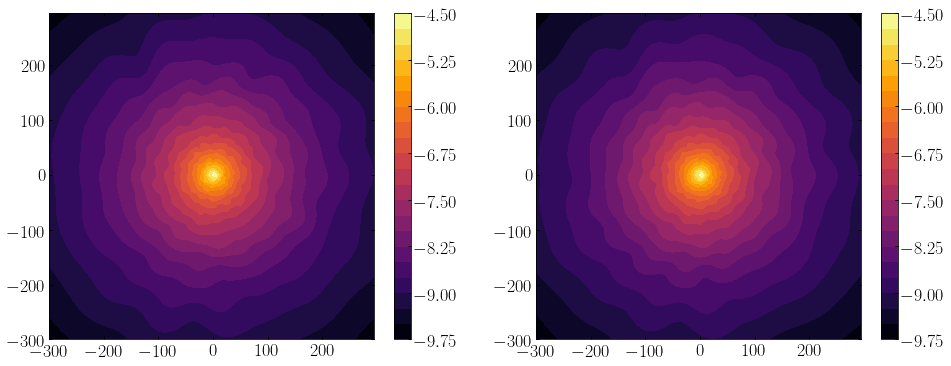

In [33]:
figure(figsize=(16,6))
subplot(1, 2, 1)
contourf(y_grid, z_grid, np.log10(np.abs(rho_mwlmc_all)).reshape(120, 120), 20,
         origin='lower', cmap='inferno')

#xlim(-20, 20)
#ylim(-20, 20)
colorbar()

subplot(1, 2, 2)
contourf(y_grid, z_grid, np.log10(np.abs(rho_mwlmc_opt)).reshape(120, 120), 20,
         origin='lower', cmap='inferno')

#xlim(-20, 20)
#ylim(-20, 20)
colorbar()

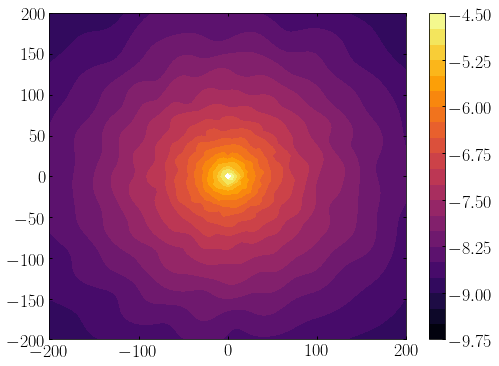

In [23]:
figure(figsize=(8,6))
